In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.stats import kstest
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
import numpy as np

Pergunta:

Será possível indicar cervejas que o usuário vai gostar, sabendo quais ele já experimentou? E, se for possível, quão bem podemos fazer isso? Se conseguirmos recomendar apenas cervejas semelhantes às que ele gosta, estaremos empurrando-o para uma bolha?

Detalhar o get, de onde esses dados vieram e o que eles significam

GET: https://www.kaggle.com/code/ruthgn/data-cleaning-integration-pandas-fuzzywuzzy/input?select=beer_reviews.csv

In [73]:
df = pd.read_csv('beer_rantings.csv')

In [74]:
#Quantas colunas (features) nós possuímos?

In [75]:
df.shape

(1586614, 13)

In [76]:
 #Resumo com detalhes sobre o DataFrame.

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1586614 non-null  int64  
 1   brewery_name        1586599 non-null  object 
 2   review_time         1586614 non-null  int64  
 3   review_overall      1586614 non-null  float64
 4   review_aroma        1586614 non-null  float64
 5   review_appearance   1586614 non-null  float64
 6   review_profilename  1586266 non-null  object 
 7   beer_style          1586614 non-null  object 
 8   review_palate       1586614 non-null  float64
 9   review_taste        1586614 non-null  float64
 10  beer_name           1586614 non-null  object 
 11  beer_abv            1518829 non-null  float64
 12  beer_beerid         1586614 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


In [78]:
# Parece que temos os dados completos mas algumas há alguns reviews cervejas que não apresentam brewery_name, review_profilename, beer_abv. 
# Vamos remover os reviews sem nome de usuario já que nao vai ser possivel identifica-los.
# Cervejas sem 

df = df.dropna(subset=['review_profilename'])

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1586266 entries, 0 to 1586613
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1586266 non-null  int64  
 1   brewery_name        1586251 non-null  object 
 2   review_time         1586266 non-null  int64  
 3   review_overall      1586266 non-null  float64
 4   review_aroma        1586266 non-null  float64
 5   review_appearance   1586266 non-null  float64
 6   review_profilename  1586266 non-null  object 
 7   beer_style          1586266 non-null  object 
 8   review_palate       1586266 non-null  float64
 9   review_taste        1586266 non-null  float64
 10  beer_name           1586266 non-null  object 
 11  beer_abv            1518493 non-null  float64
 12  beer_beerid         1586266 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 169.4+ MB


In [80]:
# Informações como média, desvio padrão, valor mínimo, quartis e valor máximo para cada coluna numérica.

In [81]:
df.describe()

,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
count,1.586266e+06,1.586266e+06,1.586266e+06,1.586266e+06,1.586266e+06,1.586266e+06,1.586266e+06,1.518493e+06,1.586266e+06
mean,3.130358e+03,1.224100e+09,3.815628e+00,3.735686e+00,3.841671e+00,3.743753e+00,3.792921e+00,7.042479e+00,2.171498e+04
std,5.578457e+03,7.654430e+07,7.205948e-01,6.975674e-01,6.160650e-01,6.821753e-01,7.319122e-01,2.322562e+00,2.181927e+04
min,1.000000e+00,8.406720e+08,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,3.000000e+00
25%,1.430000e+02,1.173236e+09,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,5.200000e+00,1.717000e+03
50%,4.290000e+02,1.239223e+09,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.500000e+00,1.390600e+04
75%,2.372000e+03,1.288572e+09,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,8.500000e+00,3.944100e+04
max,2.800300e+04,1.326285e+09,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.770000e+01,7.731700e+04


In [82]:
#Inspecionar rapidamente os 10 dados iniciais.

In [83]:
df.head(10)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883
5,1075,Caldera Brewing Company,1325524659,3.0,3.5,3.5,oline73,Herbed / Spiced Beer,3.0,3.5,Caldera Ginger Beer,4.7,52159
6,1075,Caldera Brewing Company,1318991115,3.5,3.5,3.5,Reidrover,Herbed / Spiced Beer,4.0,4.0,Caldera Ginger Beer,4.7,52159
7,1075,Caldera Brewing Company,1306276018,3.0,2.5,3.5,alpinebryant,Herbed / Spiced Beer,2.0,3.5,Caldera Ginger Beer,4.7,52159
8,1075,Caldera Brewing Company,1290454503,4.0,3.0,3.5,LordAdmNelson,Herbed / Spiced Beer,3.5,4.0,Caldera Ginger Beer,4.7,52159
9,1075,Caldera Brewing Company,1285632924,4.5,3.5,5.0,augustgarage,Herbed / Spiced Beer,4.0,4.0,Caldera Ginger Beer,4.7,52159


Beer_ABV é a sigla para 'Álcool por volume', e representa o teor alcoólico de uma cerveja, expresso em porcentagem. É uma medida importante que indica a quantidade de álcool presente em relação ao volume total da cerveja.

A coluna "review_overall" pode ser extremamente útil em análises de cervejas, pois representa a avaliação geral atribuída por revisores ou usuários.

A coluna "review_taste" representa a avaliação do sabor da cerveja. Valores mais altos indicam maior apreciação do sabor. É útil para entender as preferências dos revisores.

A coluna 'review_aroma' representa a avaliação do aroma da cerveja. Valores mais altos indicam maior apreciação do aroma. É útil para entender as preferências dos revisores em relação às características aromáticas das cervejas analisadas


A coluna 'review_appearance' representa a avaliação da aparência da cerveja. Valores mais altos indicam maior apreciação da aparência. É útil para entender as preferências dos revisores em relação aos aspectos visuais das cervejas analisadas, como cor, espuma e clareza.

A coluna 'review_palate' representa a avaliação do paladar (textura e sensação na boca) da cerveja. Valores mais altos indicam maior apreciação do paladar. É útil para entender as preferências dos revisores em relação às características sensoriais e texturais das cervejas analisadas, contribuindo para uma compreensão mais completa da experiência de degustação

In [84]:
df.nunique()

brewery_id               5840
brewery_name             5742
review_time           1577615
review_overall             10
review_aroma                9
review_appearance          10
review_profilename      33387
beer_style                104
review_palate               9
review_taste                9
beer_name               56856
beer_abv                  530
beer_beerid             66051
dtype: int64

In [85]:
df

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586609,14359,The Defiant Brewing Company,1162684892,5.0,4.0,3.5,maddogruss,Pumpkin Ale,4.0,4.0,The Horseman's Ale,5.2,33061
1586610,14359,The Defiant Brewing Company,1161048566,4.0,5.0,2.5,yelterdow,Pumpkin Ale,2.0,4.0,The Horseman's Ale,5.2,33061
1586611,14359,The Defiant Brewing Company,1160702513,4.5,3.5,3.0,TongoRad,Pumpkin Ale,3.5,4.0,The Horseman's Ale,5.2,33061
1586612,14359,The Defiant Brewing Company,1160023044,4.0,4.5,4.5,dherling,Pumpkin Ale,4.5,4.5,The Horseman's Ale,5.2,33061


Voltando para Review_overall

In [86]:
overall = df['review_overall']
overall.describe()

count    1.586266e+06
mean     3.815628e+00
std      7.205948e-01
min      0.000000e+00
25%      3.500000e+00
50%      4.000000e+00
75%      4.500000e+00
max      5.000000e+00
Name: review_overall, dtype: float64

In [87]:
overall.value_counts()

4.0    582684
4.5    324323
3.5    301750
3.0    165583
5.0     91299
2.5     58486
2.0     38207
1.5     12973
1.0     10954
0.0         7
Name: review_overall, dtype: int64

A variável "review_overall" é uma variável discreta, pois representa uma avaliação geral de uma cerveja atribuída por revisores em uma escala finita de 1 a 5.

In [88]:
df

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586609,14359,The Defiant Brewing Company,1162684892,5.0,4.0,3.5,maddogruss,Pumpkin Ale,4.0,4.0,The Horseman's Ale,5.2,33061
1586610,14359,The Defiant Brewing Company,1161048566,4.0,5.0,2.5,yelterdow,Pumpkin Ale,2.0,4.0,The Horseman's Ale,5.2,33061
1586611,14359,The Defiant Brewing Company,1160702513,4.5,3.5,3.0,TongoRad,Pumpkin Ale,3.5,4.0,The Horseman's Ale,5.2,33061
1586612,14359,The Defiant Brewing Company,1160023044,4.0,4.5,4.5,dherling,Pumpkin Ale,4.5,4.5,The Horseman's Ale,5.2,33061


In [89]:
df['beer_style'].nunique()

104

Vemos aqui que possuimos 104 intervalos possíveis para o estilos de cervejas

Vamo agora analisar as colunas que tem valores subjetivos dados pelos usuários

In [90]:
colunas = ['review_overall','review_aroma','review_appearance','review_palate','review_taste'] 

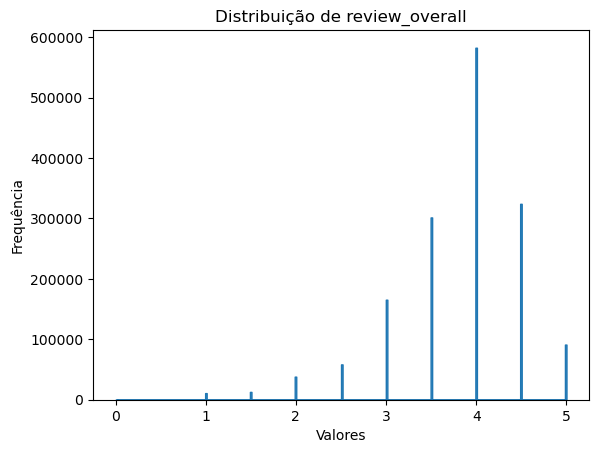

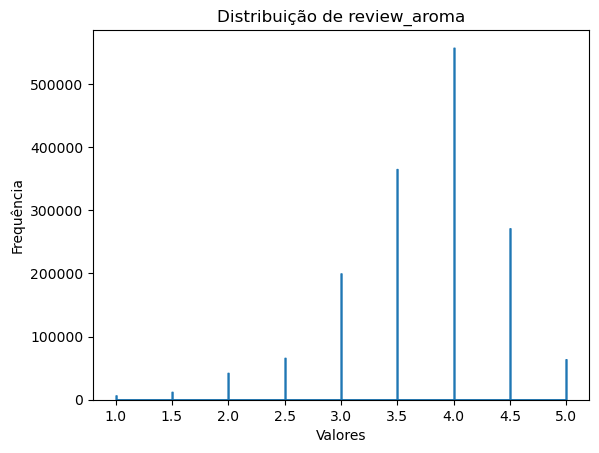

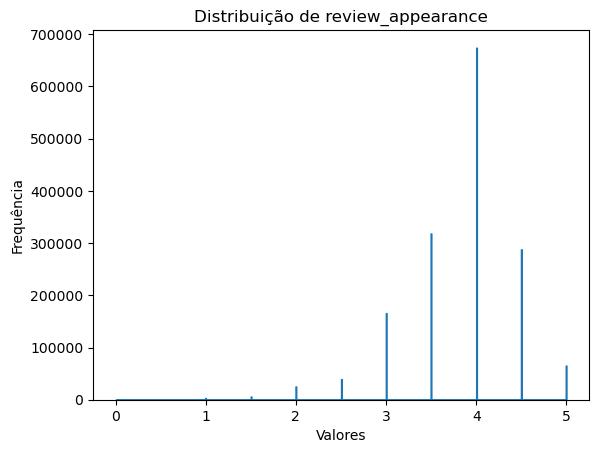

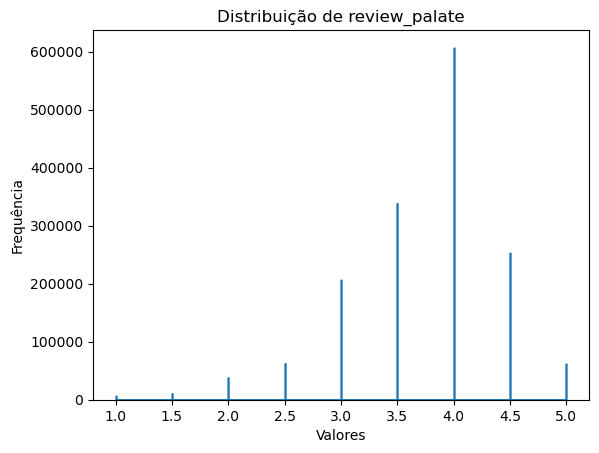

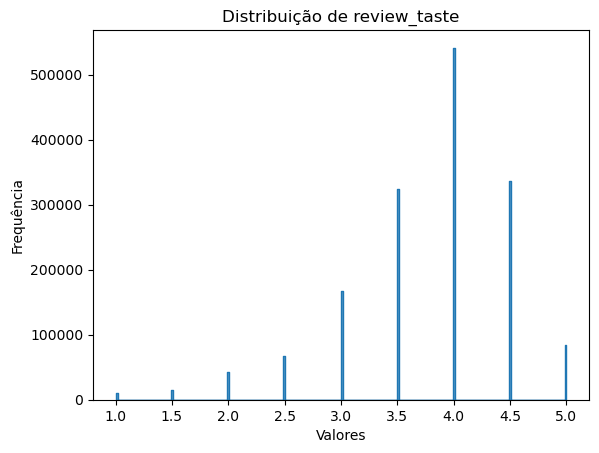

In [91]:
for coluna in colunas:
    sns.histplot(data=df, x=coluna, element="step")

# Adicionar rótulos e título ao gráfico
    plt.xlabel('Valores')
    plt.ylabel('Frequência')
    plt.title(f'Distribuição de {coluna}')

# Exibir o gráfico
    plt.show()

Uau, de certa forma todas colunas parecem seguir o mesmo padrão de distribuição...

Sabemos que as colunas analisadas são dados númericos discretos.

Existe então a hipotose de que esses dados seguem a distribuição de Poisson, agora vamos verificar

In [92]:
for coluna in colunas:
    
    media = df[coluna].mean()
    
    var = df[coluna].var()
    
    dist_poisson = poisson(media)

    ks_statistic, p_value = kstest(df[coluna], dist_poisson.cdf)
    
    print(p_value)
            
    #não consegui realizar testes estatísticos para descobrir a distribuição.


0.0
0.0
0.0
0.0
0.0


In [93]:
#Parece que realmente não é Poisson. Mas se olharmos novamente os gráficos ... 

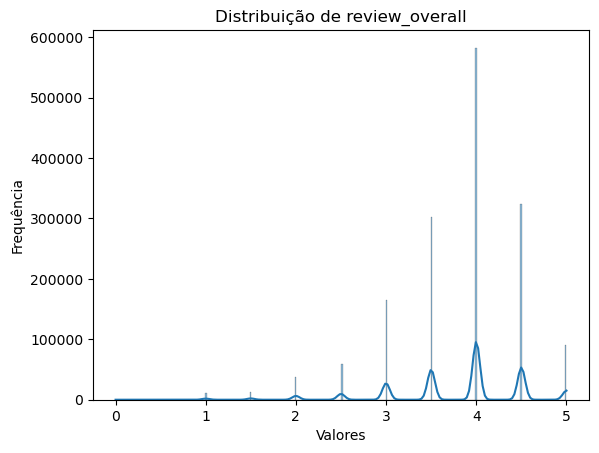

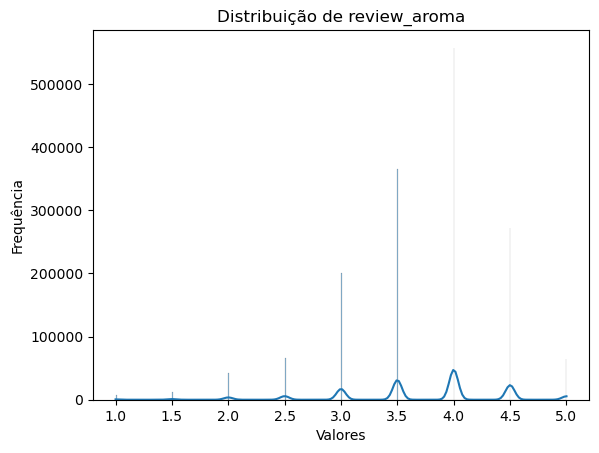

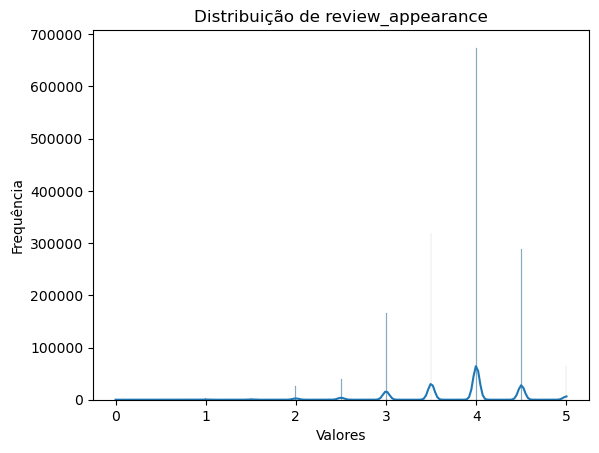

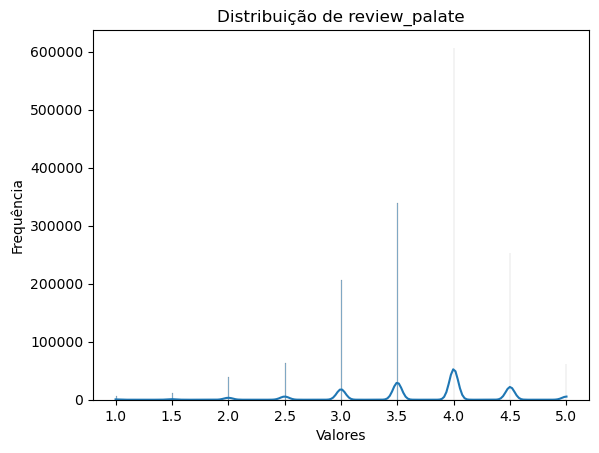

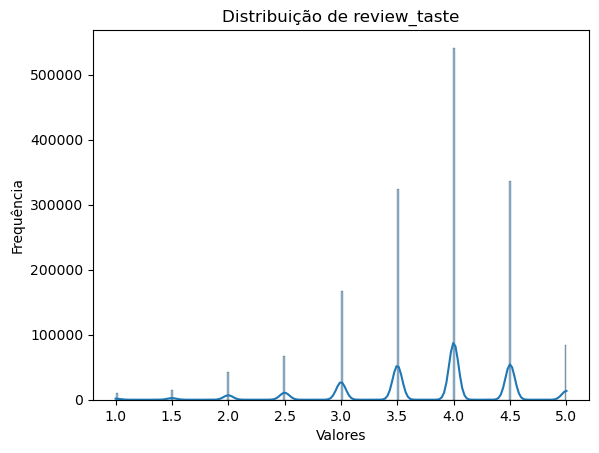

In [94]:
for coluna in colunas:
    sns.histplot(data=df, x=coluna, kde = True)

# Adicionar rótulos e título ao gráfico
    plt.xlabel('Valores')
    plt.ylabel('Frequência')
    plt.title(f'Distribuição de {coluna}')

# Exibir o gráfico
    plt.show()

Será que existem colunas que são explicadas por outras colunas?

Vamos fazer o coeficiente de correlação de spearman, ja que nossos dados são

In [95]:
colunas_t = ['review_overall','review_aroma','review_appearance','review_palate','review_taste']
notas = df.filter(items=colunas_t)

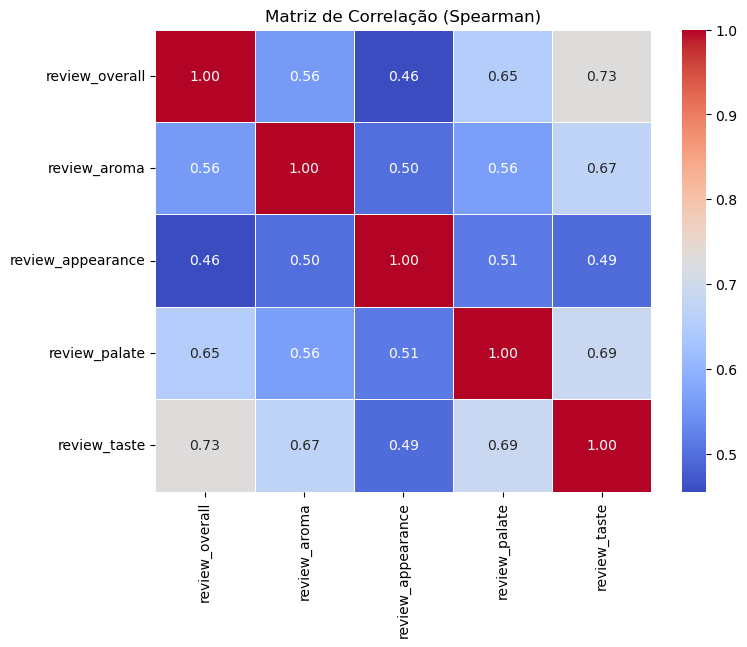

In [96]:
import seaborn as sns
matriz_correlacao = notas.corr(method='spearman')

# Plotar o mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação (Spearman)")
plt.show()

Opa, temos variaveis que são explicadas através de outras, como por exemplo a coluna taste reflete overall e vice-versa, o que faz certo sentido.

In [97]:
df['beer_style'].nunique()

104

Uau, 104 estilos diferentes, acho que isso não nos ajuda tanto rs. Será que esses estilos não são entre si semelhantes?

In [98]:
media_por_usuario = df.groupby('beer_beerid')['review_overall'].mean()
media_por_aroma = df.groupby('beer_beerid')['review_aroma'].mean()
media_por_aparencia = df.groupby('beer_beerid')['review_appearance'].mean()
media_por_palato = df.groupby('beer_beerid')['review_palate'].mean()
media_por_taste = df.groupby('beer_beerid')['review_taste'].mean()

# Criar um DataFrame para cada média
df_media_usuario = pd.DataFrame({'beer_beerid': media_por_usuario.index, 'media_usuario': media_por_usuario.values})
df_media_aroma = pd.DataFrame({'beer_beerid': media_por_aroma.index, 'media_aroma': media_por_aroma.values})
df_media_aparencia = pd.DataFrame({'beer_beerid': media_por_aparencia.index, 'media_aparencia': media_por_aparencia.values})
df_media_palato = pd.DataFrame({'beer_beerid': media_por_palato.index, 'media_palato': media_por_palato.values})
df_media_taste = pd.DataFrame({'beer_beerid': media_por_taste.index, 'media_taste': media_por_taste.values})

# Unir os DataFrames usando a coluna "beer_beerid" como chave primária
df_merged = pd.merge(df_media_usuario, df_media_aroma, on='beer_beerid', how='inner')
df_merged = pd.merge(df_merged, df_media_aparencia, on='beer_beerid', how='inner')
df_merged = pd.merge(df_merged, df_media_palato, on='beer_beerid', how='inner')
df_merged = pd.merge(df_merged, df_media_taste, on='beer_beerid', how='inner')


df_merged = pd.merge(df_merged, df[['beer_beerid', 'beer_style']], on='beer_beerid', how='left')


df_merged = df_merged.drop_duplicates(subset='beer_beerid')

df_merged['beer_style_id'] = pd.factorize(df_merged['beer_style'])[0]

# Exibindo o DataFrame após a substituição
df_merged.head(30)


,beer_beerid,media_usuario,media_aroma,media_aparencia,media_palato,media_taste,beer_style,beer_style_id
0,3,4.166667,4.000000,3.833333,4.166667,4.166667,American IPA,0
3,4,3.700000,3.800000,3.950000,3.700000,3.450000,American Stout,1
13,5,3.549528,3.205189,3.485849,3.318396,3.340802,Vienna Lager,2
437,6,3.706956,3.515964,3.836374,3.513113,3.645382,English Brown Ale,3
1314,7,3.266313,3.179059,3.251138,3.106980,3.101669,Fruit / Vegetable Beer,4
1973,8,3.647059,3.080882,3.294118,3.301471,3.235294,American Adjunct Lager,5
2041,9,3.400862,2.853448,3.051724,3.103448,3.043103,American Pale Lager,6
2157,10,3.826117,3.747207,3.936453,3.742318,3.767458,Dubbel,7
2873,11,3.394118,3.388235,3.500000,3.235294,3.270588,Scottish Ale,8
2958,12,3.709302,3.767442,4.075581,3.534884,3.686047,Russian Imperial Stout,9


In [101]:
import plotly
import plotly.graph_objects as go

# Configurar os dados para o gráfico de dispersão 3D
scatter_3d = go.Scatter3d(
    x=df_merged['beer_style_id'],
    y=df_merged['media_taste'],
    z=df_merged['media_palato'],
    
    mode='markers',
    
    text=df_merged['beer_beerid'],  # Usaremos o 'beer_beerid' como texto para identificação de cada ponto
   
    marker=dict(
size = df_merged['media_aroma']* 3,
        color=df_merged['media_aparencia'],  # Usaremos o 'media_aroma' para colorir os pontos (quanto menor o valor, mais claro o azul)
        colorscale='Inferno',  # Escolhemos a escala de cores Inferno para a coloração
        opacity=0.75,
        colorbar=dict(title='Média do Aparência'),
        line=dict(width=0)
    )
)

# Configurar o layout do gráfico
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='beer_style_id'),
        yaxis=dict(title='Média do Sabor'),
        zaxis=dict(title='Média do Palato')
    )
)

# Criar a figura do gráfico e plotar
fig = go.Figure(data=[scatter_3d], layout=layout)
plotly.offline.plot(fig, filename='grafico.html', auto_open=True)

'grafico.html'

In [ ]:
#Interessante parece que os dados seguem algum padrão e então podemos considerar a review_overall como ponto chave
# da analise de cada usuário mas sera que temos um preferencia por estilo de cerveja

In [71]:

#Import modules
import plotly
import plotly.graph_objs as go

#Make Plotly figure
fig1 = go.Scatter(x=df_merged['beer_beerid'],
    y=df_merged['media_usuario'],
    mode='markers',
                 
    marker=dict(
        color=df_merged['beer_style_id'],  # Usaremos o 'media_aroma' para colorir os pontos (quanto menor o valor, mais claro o azul)
        colorscale='Viridis',  # Escolhemos a escala de cores Inferno para a coloração
        opacity=0.75,
        colorbar=dict(title='Média do Aparência'),
        line=dict(width=0)
    )
)

#Make Plot.ly Layout
mylayout = go.Layout(xaxis=dict(title="beer_beerid"),
                     yaxis=dict( title="media_usuario"))

#Plot and save html
plotly.offline.plot({"data": [fig1],
                     "layout": mylayout},
                     auto_open=True)

'temp-plot.html'

In [ ]:
# Parece que não há uma relação entre o estilo de cerveja e media o gosto das cervejas é bem diversificado.